In [1]:
import csv
import datetime
import errno
from msilib.schema import Error
from time import time
from turtle import pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from prophet import Prophet

def calc_avg(lst):
    total = 0
    for element in lst:
        total += element
    if len(lst) < 1:
        return 0
    else:
        return total/len(lst)
    
def read_data(filename):
    nprocs = []
    runtime = []
    total_jobs = []
    submit_time = []
    total = []
    core_count = []
    r = []
    
    
    with open(filename) as file:
        tsv_file = csv.reader(file)
    
        last_time = -1
        last_hour = -1
        job_count = 0
        last_submitted = -1
        
        for line in tsv_file:
            new_line = line[0].split()

            if (float(new_line[3]) > -0.5) and (float(new_line[4]) > -0.5):
                submitted = int(new_line[1])
                dt = datetime.datetime.fromtimestamp(submitted)
                time_hour = dt.hour

                if last_hour == -1:
                    last_hour = time_hour
                    last_time = dt
                
                if last_hour != time_hour:
                    avg_runt = calc_avg(r)
                    avg_core = calc_avg(core_count)
                    runtime.append(avg_runt)
                    nprocs.append(avg_core)
                    total_jobs.append(job_count)
                    total.append(job_count * avg_core * avg_runt)
                    submit_time.append(dt.replace(minute=0, second=0, microsecond=0))
                    last_time = dt
                    job_count = 0
                    core_count.clear
                    r.clear
                    last_submitted = -1
                
                core_count.append(float(new_line[4])) # number of allocated processors
                r.append(float(new_line[3])) # runtime of the job
                job_count += 1
                last_submitted = submitted
                last_hour = time_hour
    return submit_time, runtime, nprocs, total_jobs, total

def read_dataframe():
    # NASA-iPSC.swf - error 1.0802237178635774
    # LANL-CM5.swf - error 1.2069252512929036
    # SDSC-Par.swf - error 3.144770516587491
    # CTC-SP2.swf - error 3.443897526742388
    # KIT-FH2.swf - error 0.4834554620308152 # best one so far
    # UniLu-Gaia.swf - error 33.78367153102926
    # CEA-Curie.swf - error 5.146999700882833
    # RICC.swf - error 23.571579699001585
    # PIK-IPLEX.swf - error 0.9741647366325702
    # METACENTRUM-2009-2.swf - error 26.908439064650427
    # ANL-Intrepid-2009-1.swf - error 0.6274452979102779
    # LLNL-Thunder-2007-1.1-cln.swf - error 2.172036123268631
    # LLNL-Atlas-2006-2.1-cln.swf - error 1.7332530519948632
    # LLNL-uBGL-2006-2.swf - error 1.6042098264872913
    # LPC-EGEE-2004-1.2-cln.swf - error 1.5901198265138061
    # SDSC-DS-2004-2.1-cln.swf - error 1.1862902994659887
    # HPC2N-2002-2.2-cln.swf - error 3.621939449676512
    # Sandia-Ross-2001-1.1-cln.swf - error 1.0169914656497514
    # SDSC-BLUE-2000-4.2-cln.swf - error 0.8611830141688007
    # OSC-Clust-2000-3.1-cln.swf - error 1.1377136715750191
    # LANL-O2K-1999-2.swf - error 1.563154642378174
    # SDSC-SP2-1998-4.2-cln.swf - error 0.8982790083126968
    # KTH-SP2-1996-2.1-cln.swf - error 1.370160665457865
    # LLNL-T3D-1996-2.swf - error 1.5032736577199082
    submit_time, runtime, nprocs, total_jobs, mil_core_sec = read_data('KIT-FH2.swf')
    df = pd.DataFrame(list(zip(submit_time, runtime, nprocs, total_jobs, mil_core_sec)), columns=['ds', 'RunTime', 'NProcs', 'TotalJobs', 'MilCoreSec'])
    # df.to_pickle('total_jobs_dataframe')
    return df

def load_dataframe():
    return pd.read_pickle('total_jobs_dataframe')

def generate_plot(x_axis, y_axis, title, x_label, y_label):
    fig = plt.figure()
    fig.canvas.manager.set_window_title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_axis, y_axis)
    plt.show()

def getCpuUtilization(df: pd.DataFrame):
    cpu = []
    for i in range(0,24):
        cores = df.iloc[i]['NProcs']
        jobs = df.iloc[i]['TotalJobs']
        cpu.append(cores*jobs/400)
    return cpu

def generate_workload(df: pd.DataFrame):
    critical_job_rate = 0.6
    start_time = 17

    f = open('workload.csv', 'w', newline='')
    writer = csv.writer(f, lineterminator="\n")  # use linux style line endings
    cpuUsage = getCpuUtilization(df)
    time_counter = 0
    while time_counter < 86400:  # generate for whole day
        # calculating adapted values
        current_hour = int(time_counter / 3600)
        adapted_hour = (current_hour + start_time) % 24         
        #print("current hour: " + str(adapted_hour))
        #print("job interval adapted: " + str(adapted_frame['InterArrivalTime']))

        label = ""
        if random.random() > critical_job_rate:
            label = "not-critical"
        else:
            label = "critical"
        print("cpu percent", cpuUsage[adapted_hour])
        total_cpu_usage = int(cpuUsage[adapted_hour] * 4000) # 4000 millicores rounded
        print("cpu total", total_cpu_usage)
        total_jobs = df.iloc[adapted_hour]['TotalJobs']
        print("jobs total", total_jobs)
        cpu_usage_per_job = total_cpu_usage/total_jobs
        runtime = df.iloc[adapted_hour]['RunTime']
        job_interval = int(3600/total_jobs)
        write_data = [str(int(cpu_usage_per_job)), str(int(runtime)),
                    str(int(job_interval)), label]
        #print(write_data)
        writer.writerow(write_data)
        time_counter = int(time_counter) + int(job_interval)
    f.close()

In [2]:
df = read_dataframe()

print(df)

                      ds       RunTime       NProcs  TotalJobs    MilCoreSec
0    1970-01-01 22:00:00  14400.000000   100.000000          2  2.880000e+06
1    1970-01-02 07:00:00   9615.000000    73.333333          1  7.051000e+05
2    1970-01-02 08:00:00   5026.833333    37.166667          3  5.604919e+05
3    1970-01-02 11:00:00  29562.571429   174.714286          1  5.165004e+06
4    1970-01-02 12:00:00  23037.333333  1531.444444          2  7.056079e+07
...                  ...           ...          ...        ...           ...
9495 1971-08-06 11:00:00  17757.828546   198.467958         43  1.515475e+08
9496 1971-08-06 12:00:00  17746.578659   198.372697         74  2.605123e+08
9497 1971-08-06 13:00:00  17734.653796   198.284805         79  2.778045e+08
9498 1971-08-06 14:00:00  17726.012048   198.200327         57  2.002582e+08
9499 1971-08-06 15:00:00  17719.039820   198.148060         46  1.615057e+08

[9500 rows x 5 columns]


<AxesSubplot:xlabel='ds'>

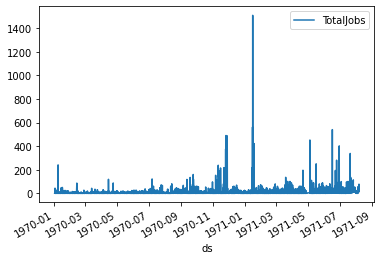

In [3]:
df.plot(x='ds', y='TotalJobs')

In [18]:
from sklearn.metrics import mean_absolute_percentage_error as mape
#Params
start_offset = 1
offset = 1
steps = 24
#Build data frames for prediction
#nprocs = df[['ds','NProcs']]
#nprocs = nprocs.rename(columns={"NProcs": "y"})

#runtime = df[['ds','RunTime']]
#runtime = runtime.rename(columns={"RunTime": "y"})

totaljobs = df[['ds','TotalJobs']]
totaljobs = totaljobs.rename(columns={"TotalJobs": "y"})


In [19]:
#Offsetting and train splitting
#nprocs_offset = nprocs[start_offset:-offset]
#runtime_offset = runtime[:-offset]
totaljobs_offset = totaljobs[:-offset]

#nprocs_train = nprocs_offset[:-steps]
#nprocs_test = nprocs_offset[-steps:]

#runtime_train = runtime_offset[:-steps]
#runtime_test = runtime_offset[-steps:]

totaljobs_train = totaljobs_offset[:-steps]
totaljobs_test = totaljobs_offset[-steps:]

16:36:46 - cmdstanpy - INFO - Chain [1] start processing
16:36:48 - cmdstanpy - INFO - Chain [1] done processing


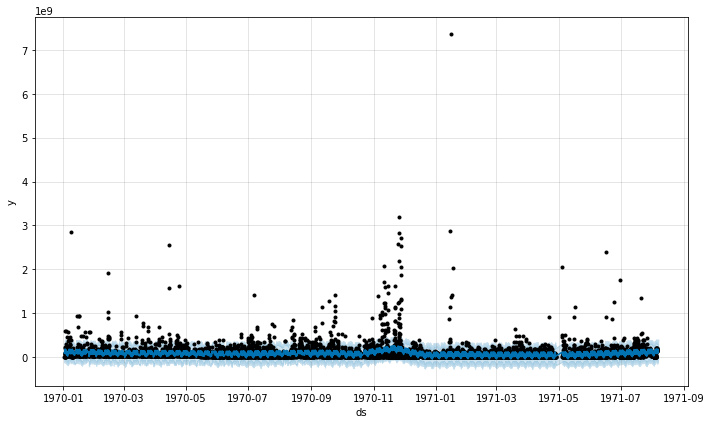

In [25]:
m_totaljobs = Prophet()
m_totaljobs.fit(totaljobs_train)

future_totaljobs = m_totaljobs.make_future_dataframe(periods=24, freq='H')
future_totaljobs.tail()

forecast_totaljobs = m_totaljobs.predict(future_totaljobs)

fig1 = m_totaljobs.plot(forecast_totaljobs)

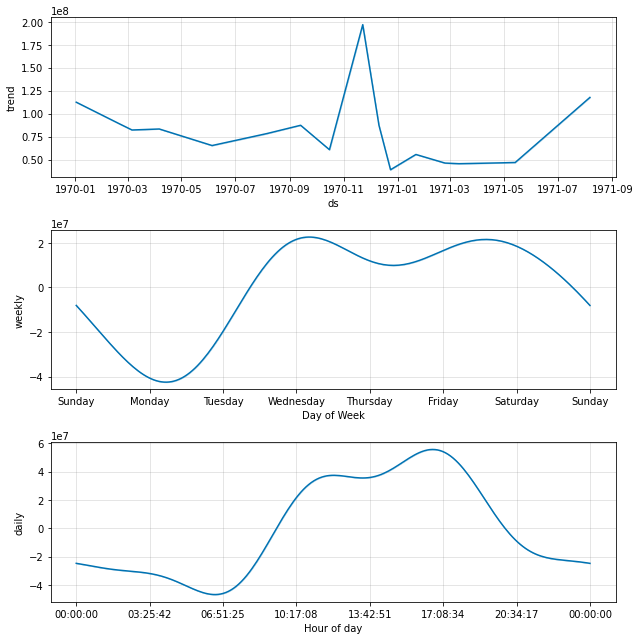

In [26]:
fig2 = m_totaljobs.plot_components(forecast_totaljobs)

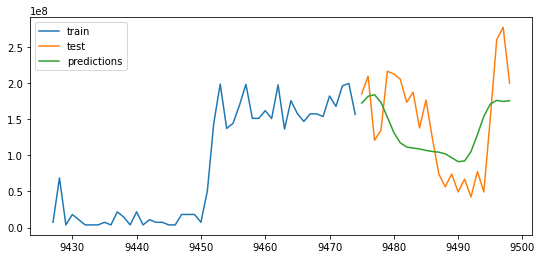

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))
totaljobs_train[-steps*2:]['y'].plot(ax=ax, label='train')
totaljobs_test['y'].plot(ax=ax, label='test')
forecast_totaljobs['yhat'][-steps:].plot(ax=ax, label='predictions')
ax.legend()

In [28]:
print(mape(totaljobs_test['y'], forecast_totaljobs['yhat'][-steps:]))

0.4834554620308152


In [24]:
print(forecast_totaljobs['yhat'][-steps:])

9475    1.724874e+08
9476    1.820730e+08
9477    1.842463e+08
9478    1.735423e+08
9479    1.530537e+08
9480    1.318003e+08
9481    1.175358e+08
9482    1.116590e+08
9483    1.102270e+08
9484    1.089865e+08
9485    1.069482e+08
9486    1.054046e+08
9487    1.045344e+08
9488    1.022253e+08
9489    9.692697e+07
9490    9.136338e+07
9491    9.229512e+07
9492    1.052827e+08
9493    1.288964e+08
9494    1.542586e+08
9495    1.712569e+08
9496    1.763510e+08
9497    1.749326e+08
9498    1.759022e+08
Name: yhat, dtype: float64
